# Forecasting

## Preparação dos Dados

In [ ]:
%pip install --upgrade numpy==1.26.4

In [1]:
import pandas as pd
import tarfile
import io

# Função para extrair arquivos .tar.xz e ler os CSVs
def load_data_from_tarxz(tarxz_path, filename):
    with tarfile.open(tarxz_path, "r:xz") as tar:
        file = tar.extractfile(filename)
        dataframe = pd.read_csv(io.BytesIO(file.read()))
    return dataframe

# Caminhos para os arquivos .tar.xz e o arquivo CSV não compactado
tarxz_paths = {
    'item_prices': '../data/item_prices.tar.xz',
    'item_sales': '../data/item_sales.tar.xz'
}

filenames = {
    'item_prices': 'item_prices.csv',
    'item_sales': 'item_sales.csv'
}

# Carregar o arquivo CSV não compactado diretamente
calendar_path = '../data/daily_calendar_with_events.csv'

# Carregar os dados compactados
item_prices = load_data_from_tarxz(tarxz_paths['item_prices'], filenames['item_prices'])
item_sales = load_data_from_tarxz(tarxz_paths['item_sales'], filenames['item_sales'])

# Carregar o arquivo não compactado
daily_calendar = pd.read_csv(calendar_path)

# Verificar valores nulos
item_prices.fillna(item_prices.select_dtypes(include='number').median(), inplace=True)
item_sales.fillna(item_sales.select_dtypes(include='number').median(), inplace=True)
daily_calendar.fillna('No Event', inplace=True)

# Agregar vendas por data
sales_data = item_sales.iloc[:, 7:].sum().reset_index()
sales_data.columns = ['d', 'sales']

# Combinar com calendário para obter uma série temporal
sales_data = sales_data.merge(daily_calendar, on='d')
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Definir a série temporal
ts_sales = sales_data.set_index('date')['sales']


## Modelagem e Previsão com ARIMA

In [2]:
%pip install --upgrade pmdarima

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Would remove:
    /home/rp/Desenvolvimento/DSMarket/venv/lib/python3.11/site-packages/pmdarima-2.0.4.dist-info/*
    /home/rp/Desenvolvimento/DSMarket/venv/lib/python3.11/site-packages/pmdarima/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Dividir os dados em treino e teste
train_size = int(len(ts_sales) * 0.8)
train, test = ts_sales[:train_size], ts_sales[train_size:]

# Ajustar o modelo ARIMA
model = pm.auto_arima(train, seasonal=False, m=1, stepwise=True, suppress_warnings=True)
model.summary()

# Fazer previsões
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)


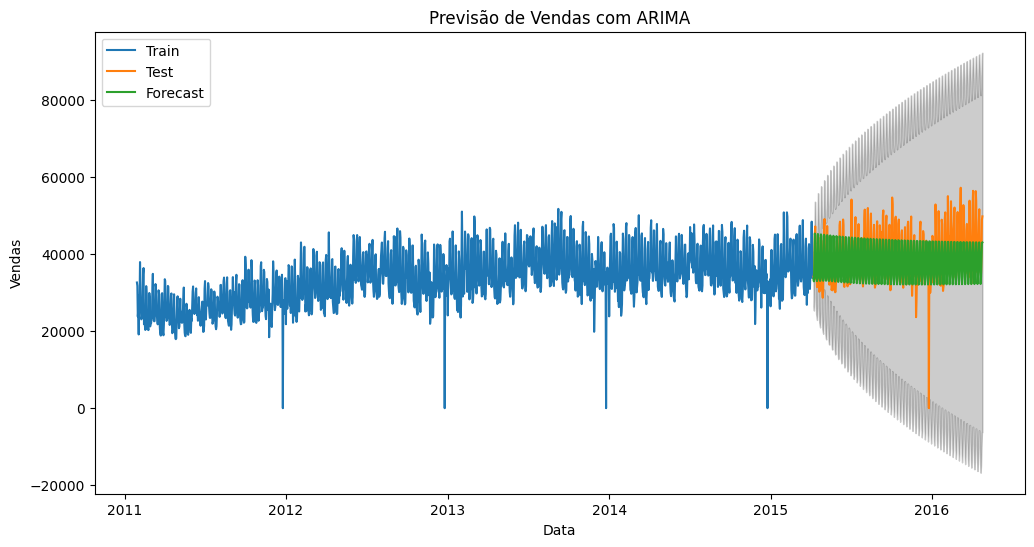

Mean Squared Error: 22466188.169526696
Mean Absolute Error: 3391.5588189950286


In [4]:
# Plotar as previsões
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.2)
plt.title('Previsão de Vendas com ARIMA')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

# Calcular métricas de avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
